# Ames, Iowa House Price Prediction

Contributors: Yuem Park

Here we just practice some regression techniques using a tabular dataset on house prices in Ames, Iowa.

**NOTE:** This notebook was executed on a Kaggle kernel, within the context of [this ongoing Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). If you'd like to fork this notebook with the associated data, please visit the version of this notebook that is hosted on Kaggle, available [here](https://www.kaggle.com/yuempark/ames-iowa-house-price-prediction).

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import math

pd.set_option('display.max_columns', 999)

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import RegressorMixin
from sklearn.base import clone

from scipy.stats import uniform
from scipy.stats import loguniform

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


## Basic Feature Engineering

In [4]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
train.shape

(1460, 81)

In [5]:
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test.shape

(1459, 80)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Before any further analysis can be done, we will need to deal with the categorical features, as well as the missing values. We'll just step through each feature as required, building up a preprocessing pipeline.

Descriptions of the features within this dataset can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

Key points:
* We label encode the categorical features that are actually ordered (e.g. where the categories reflect quality).
* We weighted target encode the non-ordered categorical features.
    * We do not label encode these features because that would imply ordering of the categories.
    * We do not one hot encode (OHE) these features since:
        * OHE vastly increases the dimensionality of the dataset
        * OHE creates sparse features that virtually ensures that continuous variables are assigned higher feature importance

In [7]:
def feature_engineering(df):
    """
    Clean up the features that require some specific attention.
    """
    
    # features that need imputing (use intuition to determine method for each feature)
    df['LotFrontage'].fillna(np.nanmean(train['LotFrontage']), inplace=True)
    df['MasVnrType'].fillna('None', inplace=True)
    df['MasVnrArea'].fillna(np.nanmean(train['MasVnrArea']), inplace=True)
    df['Electrical'].fillna('SBrkr', inplace=True)
    df.loc[df['GarageYrBlt'].isna(),'GarageYrBlt'] = df[df['GarageYrBlt'].isna()]['YearBuilt']
    df['BsmtFinSF1'].fillna(np.nanmean(train['BsmtFinSF1']), inplace=True)
    df['BsmtFinSF2'].fillna(np.nanmean(train['BsmtFinSF2']), inplace=True)
    df['BsmtUnfSF'].fillna(np.nanmean(train['BsmtUnfSF']), inplace=True)
    df['TotalBsmtSF'].fillna(np.nanmean(train['TotalBsmtSF']), inplace=True)
    df['BsmtFullBath'].fillna(train['BsmtFullBath'].mode().values[0], inplace=True)
    df['BsmtHalfBath'].fillna(train['BsmtHalfBath'].mode().values[0], inplace=True)
    df['GarageCars'].fillna(train['GarageCars'].mode().values[0], inplace=True)
    df['GarageArea'].fillna(np.nanmean(train['GarageArea']), inplace=True)

    # label encode ordered categorical features (e.g. where the categories reflect quality)
    LE_features = []
    def ordered_label_encode(col, cats):
        """
        Label encode, but ordered.
        """
        labels = np.arange(len(cats))
        df.loc[:,col] = df[col].map(dict(zip(cats,labels)), na_action='ignore')
        df.loc[df[col].isna(),col] = len(cats)+1
        LE_features.append(col)

    ordered_label_encode('LotShape', ['Reg','IR1','IR2','IR3'])
    ordered_label_encode('Utilities', ['AllPub','NoSewr','NoSeWa','ELO'])
    ordered_label_encode('LandSlope', ['Gtl','Mod','Sev'])
    ordered_label_encode('ExterQual', ['Ex','Gd','TA','Fa','Po'])
    ordered_label_encode('ExterCond', ['Ex','Gd','TA','Fa','Po'])
    ordered_label_encode('BsmtQual', ['Ex','Gd','TA','Fa','Po'])
    ordered_label_encode('BsmtCond', ['Ex','Gd','TA','Fa','Po'])
    ordered_label_encode('BsmtExposure', ['Gd','Av','Mn','No'])
    ordered_label_encode('BsmtFinType1', ['GLQ','ALQ','BLQ','Rec','LwQ','Unf'])
    ordered_label_encode('BsmtFinType2', ['GLQ','ALQ','BLQ','Rec','LwQ','Unf'])
    ordered_label_encode('HeatingQC', ['Ex','Gd','TA','Fa','Po'])
    ordered_label_encode('CentralAir', ['Y','N'])
    ordered_label_encode('KitchenQual', ['Ex','Gd','TA','Fa','Po'])
    ordered_label_encode('Functional', ['Typ','Min1','Min2','Mod','Maj1','Maj2','Sev','Sal'])
    ordered_label_encode('FireplaceQu', ['Ex','Gd','TA','Fa','Po'])
    ordered_label_encode('GarageFinish', ['Fin','RFn','Unf'])
    ordered_label_encode('GarageQual', ['Ex','Gd','TA','Fa','Po'])
    ordered_label_encode('GarageCond', ['Ex','Gd','TA','Fa','Po'])
    ordered_label_encode('PavedDrive', ['Y','P','N'])
    ordered_label_encode('PoolQC', ['Ex','Gd','TA','Fa'])
    ordered_label_encode('Fence', ['GdPrv','MnPrv','GdWo','MnWw'])
    
    # target encode the other categorical features
    def target_encode(col, weight=None):
        total_mean = np.mean(train_y)
        cats = df[col].unique()
        if weight==None:
            weight = int((len(train)/len(cats))/2)
        for cat in cats:
            if pd.isnull(cat):
                if len(train[train[col].isna()])==0:
                    df[col].fillna(total_mean, inplace=True)
                else:
                    cat_mean = np.mean(train_y[train[col].isna()])
                    count = len(df[df[col].isna()])
                    df.loc[df[col].isna(), col] = (count*cat_mean + weight*total_mean)/(count+weight)
            else:
                if len(train[train[col]==cat])==0:
                    df.loc[df[col]==cat, col] = total_mean
                else:
                    cat_mean = np.mean(train_y[train[col]==cat])
                    count = len(df[df[col]==cat])
                    df.loc[df[col]==cat, col] = (count*cat_mean + weight*total_mean)/(count+weight)
        
    TE_features = ['MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','BldgType','HouseStyle',
                   'RoofStyle','RoofMatl','MasVnrType','Foundation','Heating','Electrical','GarageType','MiscFeature',
                   'SaleType','SaleCondition','Condition1','Condition2','Exterior1st','Exterior2nd']
    for col in TE_features:
        target_encode(col)
        
    # numerical features
    num_features = ['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MasVnrArea',
                    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
                    'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                    'TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                    'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']
    
    # features to ignore
    ignore_features = ['MSSubClass']
    
    df.drop(columns=ignore_features, inplace=True)
        
    # total area
    num_features.append('TotalSF')
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    return df, LE_features, TE_features, num_features, ignore_features

Bring train and test together temporarily so that the one-hot encoding captures all present categories.

In [8]:
train_y = train['SalePrice']

train.drop(columns='SalePrice', inplace=True)

train['set'] = 'train'
test['set'] = 'test'

train_test = pd.concat([train,test])

Pre-process, then move the splits apart again.

In [9]:
# pre-process
train_test, LE_features, TE_features, num_features, ignore_features = feature_engineering(train_test)

# split
train = train_test[train_test['set']=='train']
test = train_test[train_test['set']=='test']

# remove ID column
train_Id = train['Id'].copy()
test_Id = test['Id'].copy()

train.drop(columns=['set','Id'], inplace=True)
test.drop(columns=['set','Id'], inplace=True)

Check column consistency.

In [10]:
no_mismatch = True
for i in range(len(train.columns)):
    if train.columns[i]!=test.columns[i]:
        print('train/test mismatch : {}'.format(train.columns[i]))
        no_mismatch = False
if no_mismatch:
    print('No mismatches.')

No mismatches.


Check NaNs.

In [11]:
no_nan = True
for col in test.columns:
    if train[col].isna().sum() > 0:
        print('train : {} : {}'.format(col, train[col].isna().sum()))
        no_nan = False
    if test[col].isna().sum() > 0:
        print('test : {} : {}'.format(col, test[col].isna().sum()))
        no_nan = False
if no_nan:
    print('No NaNs.')

No NaNs.


Note that normalization is not necessary, since all algorithms that we will be using are based on decision trees, which are non-parametric.

## Further Feature Engineering

Spearman correlation:

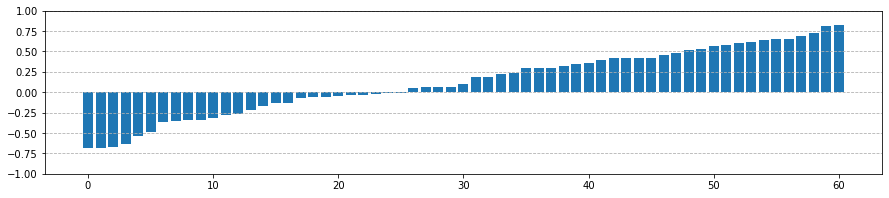

In [12]:
spearman = train.corrwith(train_y, method='spearman')
spearman.sort_values(inplace=True)

fig, ax = plt.subplots(figsize=(15,3))
x_vals = np.arange(len(spearman))
ax.bar(x_vals, spearman)
ax.set_ylim(-1,1)
ax.yaxis.grid(ls='--')
plt.show(fig)

In [13]:
spearman_abs = spearman.abs()
spearman_abs.sort_values(inplace=True, ascending=False)
for i in range(20):
    print('{} : {:.3f}'.format(spearman_abs.index[i], spearman_abs[i]))

TotalSF : 0.820
OverallQual : 0.810
GrLivArea : 0.731
GarageCars : 0.691
ExterQual : 0.684
BsmtQual : 0.678
KitchenQual : 0.673
YearBuilt : 0.653
GarageArea : 0.649
FullBath : 0.636
GarageFinish : 0.634
GarageYrBlt : 0.613
TotalBsmtSF : 0.603
1stFlrSF : 0.575
YearRemodAdd : 0.571
FireplaceQu : 0.538
TotRmsAbvGrd : 0.533
Fireplaces : 0.519
HeatingQC : 0.491
OpenPorchSF : 0.478


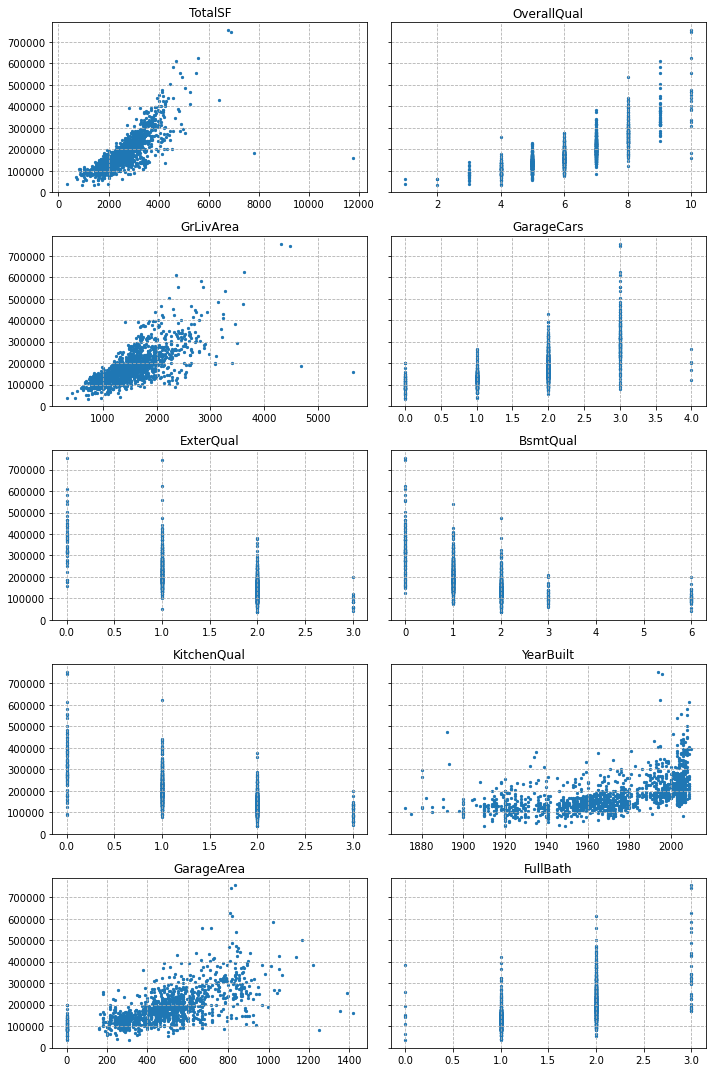

In [14]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,15), sharey=True)

ax = ax.flatten()

for i in range(10):
    ax[i].scatter(train[spearman_abs.index[i]], train_y, s=5)
    ax[i].set_title(spearman_abs.index[i])
    ax[i].grid(ls='--')
    
fig.tight_layout()
plt.show(fig)

Based on these scatter plots we can identify a few outliers - we'll get rid of them:

In [15]:
outliers = []
for i in range(len(train)):
    if train['TotalSF'][i]>7500:
        outliers.append(i)

train.drop(outliers, axis=0, inplace=True)
train_y.drop(outliers, axis=0, inplace=True)
train_Id.drop(outliers, axis=0, inplace=True)

print('n outliers = {}'.format(len(outliers)))

n outliers = 2


## Models

Let's try three variants of gradient boosted trees: a vanilla gradient boosting regressor, light gradient boosting (light GBM), and extreme gradient boosting (XGB).

We will also try a meta-learner, which uses the predictions of the three models above as additional training features.

For each model, we will tune the hyperparameters using a Bayesian hyperparameter optimization method - this method should converge on the optimal hyperparameters much faster than the more basic random/grid search approaches, which should allow us to more effectively use our computation time to fine tune the hyperparameters.

In [16]:
n_features = train.shape[1]
train.shape

(1458, 79)

Scorer:

In [17]:
# define a scorer - in this case RMSE of logs
def get_RMSE(Y, Y_prediction):
    
    Y_prediction_positive = Y_prediction
    
    # in rare instances, some models will predict negative values - so force predictions to be positive
    Y_prediction_positive[Y_prediction<=0] = 1
    
    RMSE = np.sqrt(mean_squared_error(np.log(Y), np.log(Y_prediction_positive)))
    return RMSE

# initialize the scorer
scorer = make_scorer(get_RMSE, greater_is_better=False)

# score a model on the training data using cross validation
kfolds = KFold(n_splits=5, shuffle=True, random_state=1992)
def CV_RMSE(model, x, y):
    RMSE = -cross_val_score(model, x, y, scoring=scorer, cv=kfolds)
    return RMSE

A function to evaluate whether the hyperparameter tuning is:
* exploring an appropriate hyperparameter space
* has converged on a hyperparameter set

**NOTE:** in the committed version of this notebook, the code cells that performed the hyperparameter tuning are commented out, since they are computationally expensive. However, they were run as is to obtain the hyperparameters that are used to make the final predictions.

In [18]:
def hyperopt_plot(trials, param_names, param_q, param_log):
    
    trials_summary = pd.DataFrame()
    
    i = 0
    for trial in trials.trials:
        trials_summary.loc[i,'loss'] = trial['result']['loss']
        i = i+1
        
    for param in param_names:
        i = 0
        for trial in trials.trials:
            trials_summary.loc[i,param] = trial['misc']['vals'][param][0]
            i = i+1
            
    fig, ax = plt.subplots(nrows=len(param_names)+1, ncols=2, figsize=(10,18))
    
    for i in range(len(param_names)):
        
        if param_q[i] == False:
            if param_log[i] == False:
                ax[i][0].hist(trials_summary[param_names[i]])
            else:
                hist, bins = np.histogram(trials_summary[param_names[i]])
                logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
                ax[i][0].hist(trials_summary[param_names[i]], bins=logbins)
                ax[i][0].set_xscale('log')
        else:
            sorted_df = trials_summary.sort_values(by=param_names[i])
            unique_vals = sorted_df[param_names[i]].unique()
            unique_vals_ind = np.arange(len(unique_vals))
            unique_vals_count = sorted_df[param_names[i]].value_counts(sort=False)
            ax[i][0].bar(unique_vals_ind, unique_vals_count)
            ax[i][0].set_xticks(unique_vals_ind)
            ax[i][0].set_xticklabels(unique_vals)
            
        ax[i][1].scatter(trials_summary[param_names[i]], trials_summary['loss'])
        if param_log[i] == True:
            ax[i][1].set_xscale('log')
            
        ax[i][0].set_ylabel(param_names[i])
        ax[i][1].yaxis.grid(ls='--',c='C7')
        
    ax[len(param_names)][0].scatter(np.arange(len(trials_summary)), trials_summary['loss'], c='C1')
    ax[len(param_names)][0].set_ylabel('loss')
    ax[len(param_names)][0].set_xlabel('iteration')
    ax[len(param_names)][0].yaxis.grid(ls='--',c='C7')
            
    fig.tight_layout()
    plt.show()
    
    return trials_summary

### Gradient Boosting

In [19]:
#def GBR_fn(params):
#    
#    params = {'learning_rate' : params['learning_rate'], 
#              'min_samples_leaf' : int(params['min_samples_leaf']),
#              'max_depth' : int(params['max_depth']),
#              'max_features' : int(params['max_features']),
#              'n_estimators' : int(params['n_estimators'])}
#    
#    model = GradientBoostingRegressor(random_state=2020, loss='huber', **params)
#    
#    score = np.mean(CV_RMSE(model, train.values, train_y.values))
#
#    return score

In [20]:
#hp_space = {'learning_rate' : hp.loguniform('learning_rate', low=np.log(0.005), high=np.log(0.1)), 
#            'min_samples_leaf' : hp.quniform('min_samples_leaf', low=1, high=5, q=1),
#            'max_depth' : hp.quniform('max_depth', low=2, high=5, q=1),
#            'max_features' : hp.quniform('max_features', low=2, high=20, q=2),
#            'n_estimators' : hp.quniform('n_estimators', low=3000, high=5000, q=250)}
#
#GBR_trials = Trials()
#best_GBR_params = fmin(fn=GBR_fn, space=hp_space, algo=tpe.suggest, max_evals=25*5,
#                       trials=GBR_trials, rstate=np.random.RandomState(1992))

In [21]:
#GBR_trials_summary = hyperopt_plot(GBR_trials,
#                                   ['learning_rate','min_samples_leaf','max_depth','max_features','n_estimators'],
#                                   [False          ,True              ,True       ,True          ,True],
#                                   [True           ,False             ,False      ,False         ,False])

In [22]:
#best_GBR_params

In [23]:
# this is the best GBR found using hyperopt
# commit version 15
best_GBR = GradientBoostingRegressor(random_state=2020, loss='huber',
                                     learning_rate=0.013427541181495601,
                                     min_samples_leaf=3,
                                     max_depth=3,
                                     max_features=12,
                                     n_estimators=3250)

In [24]:
score = CV_RMSE(best_GBR, train.values, train_y.values)
print('GBR     : {:.4f}'.format(score.mean()))

GBR     : 0.1118


### Light GBM

In [25]:
#def LGBM_fn(params):
#    
#    params = {'learning_rate' : params['learning_rate'],
#              'n_estimators' : int(params['n_estimators']),
#              'min_data_in_leaf' : int(params['min_data_in_leaf']),
#              'num_leaves' : int(params['num_leaves']),
#              'max_bin' : int(params['max_bin']),
#              'bagging_fraction' : params['bagging_fraction']}
#    
#    model = LGBMRegressor(random_state=2020, objective='regression', bagging_freq=5, **params)
#    
#    score = np.mean(CV_RMSE(model, train.values, train_y.values))
#
#    return score

In [26]:
#hp_space = {'learning_rate' : hp.loguniform('learning_rate', low=np.log(0.001), high=np.log(0.01)), 
#            'n_estimators' : hp.quniform('n_estimators', low=3000, high=5000, q=250),
#            'min_data_in_leaf' : hp.quniform('min_data_in_leaf', low=1, high=10, q=1),
#            'num_leaves' : hp.quniform('num_leaves', low=6, high=20, q=2),
#            'max_bin' : hp.quniform('max_bin', low=100, high=300, q=20),
#            'bagging_fraction' : hp.uniform('bagging_fraction', low=0.01, high=0.4)}
#
#LGBM_trials = Trials()
#best_LGBM_params = fmin(fn=LGBM_fn, space=hp_space, algo=tpe.suggest, max_evals=25*7,
#                        trials=LGBM_trials, rstate=np.random.RandomState(1992))

In [27]:
#LGBM_trials_summary = hyperopt_plot(LGBM_trials,
#                                    ['learning_rate','n_estimators','min_data_in_leaf','num_leaves','max_bin','bagging_fraction'],
#                                    [False          ,True          ,True              ,True        ,True     ,False             ],
#                                    [True           ,False         ,False             ,False       ,False    ,False             ])

In [28]:
#best_LGBM_params

In [29]:
# this is the best LGBM found using hyperopt
# commit version between 15 and 16
best_LGBM = LGBMRegressor(random_state=2020, objective='regression', bagging_freq=5,
                          learning_rate=0.0024914313311670865,
                          n_estimators=3250,
                          min_data_in_leaf=5,
                          num_leaves=18,
                          max_bin=280,
                          bagging_fraction=0.21845235737733873)

In [30]:
score = CV_RMSE(best_LGBM, train.values, train_y.values)
print('LGBM : {:.4f}'.format(score.mean()))

LGBM : 0.1143


### XG Boost

In [31]:
#def XGB_fn(params):
#    
#    params = {'learning_rate' : params['learning_rate'],
#              'n_estimators' : int(params['n_estimators']),
#              'max_depth' : int(params['max_depth']),
#              'min_child_weight' : int(params['min_child_weight']),
#              'subsample' : params['subsample'],
#              'colsample_bytree' : params['colsample_bytree'],
#              'reg_alpha' : params['reg_alpha']}
#    
#    model = XGBRegressor(random_state=2020, objective='reg:squarederror', **params)
#    
#    score = np.mean(CV_RMSE(model, train.values, train_y.values))
#
#    return score

In [32]:
#hp_space = {'learning_rate' : hp.loguniform('learning_rate', low=np.log(0.001), high=np.log(0.05)), 
#            'n_estimators' : hp.quniform('n_estimators', low=3000, high=5000, q=250),
#            'max_depth' : hp.quniform('max_depth', low=2, high=8, q=1),
#            'min_child_weight' : hp.quniform('min_child_weight', low=0, high=6, q=1),
#            'subsample' : hp.uniform('subsample', low=0.2, high=0.9),
#            'colsample_bytree' : hp.uniform('colsample_bytree', low=0.05, high=0.5),
#            'reg_alpha' : hp.loguniform('reg_alpha', low=np.log(0.001), high=np.log(0.5))}
#
#XGB_trials = Trials()
#best_XGB_params = fmin(fn=XGB_fn, space=hp_space, algo=tpe.suggest, max_evals=25*7,
#                       trials=XGB_trials, rstate=np.random.RandomState(1992))

In [33]:
#XGB_trials_summary = hyperopt_plot(XGB_trials,
#                                   ['learning_rate','n_estimators','max_depth','min_child_weight','subsample','colsample_bytree','reg_alpha'],
#                                   [False          ,True          ,True       ,True              ,False      ,False             ,False],
#                                   [True           ,False         ,False      ,False             ,False      ,False             ,True])

In [34]:
#best_XGB_params

In [35]:
# this is the best XGB found using hyperopt
# commit version 17
best_XGB = XGBRegressor(random_state=2020, objective='reg:squarederror',
                        learning_rate=0.005534694886280049,
                        n_estimators=4500,
                        max_depth=5,
                        min_child_weight=1,
                        subsample=0.20168620263669185,
                        colsample_bytree=0.31135298922642873,
                        reg_alpha=0.39790784811926205)

In [36]:
score = CV_RMSE(best_XGB, train.values, train_y.values)
print('XGB : {:.4f}'.format(score.mean()))

XGB : 0.1116


### Stacked Meta-Learner

In [37]:
estimators = [('GBR',best_GBR), ('LGBM',best_LGBM), ('XGB',best_XGB)]

In [38]:
#def meta_fn(params):
#    
#    params = {'learning_rate' : params['learning_rate'],
#              'n_estimators' : int(params['n_estimators']),
#              'max_depth' : int(params['max_depth']),
#              'min_child_weight' : int(params['min_child_weight']),
#              'subsample' : params['subsample'],
#              'colsample_bytree' : params['colsample_bytree'],
#              'reg_alpha' : params['reg_alpha']}
#    
#    meta_XGB = XGBRegressor(random_state=2020, objective='reg:squarederror', **params)
#    
#    model = StackingRegressor(estimators=estimators, final_estimator=meta_XGB, cv=kfolds, passthrough=True)
#    
#    score = np.mean(CV_RMSE(model, train.values, train_y.values))
#
#    return score

In [39]:
#hp_space = {'learning_rate' : hp.loguniform('learning_rate', low=np.log(0.001), high=np.log(0.05)), 
#            'n_estimators' : hp.quniform('n_estimators', low=3000, high=5000, q=250),
#            'max_depth' : hp.quniform('max_depth', low=2, high=8, q=1),
#            'min_child_weight' : hp.quniform('min_child_weight', low=0, high=6, q=1),
#            'subsample' : hp.uniform('subsample', low=0.2, high=0.9),
#            'colsample_bytree' : hp.uniform('colsample_bytree', low=0.05, high=0.5),
#            'reg_alpha' : hp.loguniform('reg_alpha', low=np.log(0.001), high=np.log(0.5))}
#
#meta_trials = Trials()
#best_meta_params = fmin(fn=meta_fn, space=hp_space, algo=tpe.suggest, max_evals=50,
#                        trials=meta_trials, rstate=np.random.RandomState(1992))

In [40]:
#meta_trials_summary = hyperopt_plot(meta_trials,
#                                    ['learning_rate','n_estimators','max_depth','min_child_weight','subsample','colsample_bytree','reg_alpha'],
#                                    [False          ,True          ,True       ,True              ,False      ,False             ,False],
#                                    [True           ,False         ,False      ,False             ,False      ,False             ,True])

In [41]:
#best_meta_params

In [42]:
# this is the best meta-learner found using hyperopt
# commit version 20
best_meta_XGB = XGBRegressor(random_state=2020, objective='reg:squarederror',
                             learning_rate=0.002274315962928884,
                             n_estimators=4000,
                             max_depth=5,
                             min_child_weight=2,
                             subsample=0.4891190054573029,
                             colsample_bytree=0.19153865229872344,
                             reg_alpha=0.2514124680611613)

best_meta = StackingRegressor(estimators=estimators, final_estimator=best_meta_XGB, cv=kfolds, passthrough=True)

In [43]:
score = CV_RMSE(best_meta, train.values, train_y.values)
print('meta : {:.4f}'.format(score.mean()))

meta : 0.1117


## Submission

Make predictions and submit:

In [44]:
best_GBR.fit(train.values, train_y.values)
best_LGBM.fit(train.values, train_y.values)
best_XGB.fit(train.values, train_y.values)
best_meta.fit(train.values, train_y.values)

# weight model predictions based on their cross-valided RMSE
test_y = (0.3 * best_GBR.predict(test.values)) + \
         (0.1 * best_LGBM.predict(test.values)) + \
         (0.3 * best_XGB.predict(test.values)) + \
         (0.3 * best_meta.predict(test.values))

sub = pd.DataFrame()
sub['Id'] = test_Id
sub['SalePrice'] = test_y
sub.to_csv('submission.csv',index=False)